In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import matplotlib.pyplot as plt


from mac0460_5832.utils import *
from ep1 import *

# MAC0460/5832 - Lista 2: Escolha de modelo

### Data de Entrega: 23h55m do dia 05/06/2017


Q1. Projete, a partir dos dados, o operador capaz de filtrar ruído usando a técnica de multiresolução. Como conjuntos de hipóteses, utilize diferentes subamostragens da janela original, como ilustrado abaixo:

1. Subamostragem 1: ![alt text](imgs/q1_h1.png "1")
2. Subamostragem 2: ![alt text](imgs/q1_h2.png "2")
3. Subamostragem 3: ![alt text](imgs/q1_h3.png "2")

Para cada conjunto, plote os erros  $E_{in}$ e $E_{val}$ ao longo do treinamento. Após escolher o modelo mais apropriado, retreine seu operador com todos os dados e imprima o erro $E_{in}$.

Utilize as imagens da pasta imgs/q1/ para realizar o treinamento e validação (nota: são as mesmas imagens do EP anterior).

In [2]:
# carrega as imagens

dest1 = read_img("imgs/q1/q1_dest.png")

src = [read_img("imgs/q1/q1_src1.png"), read_img("imgs/q1/q1_src2.png"),
       read_img("imgs/q1/q1_src3.png"), read_img("imgs/q1/q1_src4.png"),
       read_img("imgs/q1/q1_src5.png"), read_img("imgs/q1/q1_src6.png"),
       read_img("imgs/q1/q1_src7.png"), read_img("imgs/q1/q1_src8.png"),
       read_img("imgs/q1/q1_src9.png"), read_img("imgs/q1/q1_src10.png")]

# cria os padroes diferentes de box, disk e cross

l1 = [not(i%2) for i in range(5)]
l2 = [False for i in range(5)]
se_dots = np.array([l1,l2,l1,l2,l1])

se_singledot = np.zeros([5,5], dtype=bool)
se_singledot[2,2] = True

def se_border(se_inner):
    box = np.zeros([5,5], dtype=bool)
    box[1:4,1:4] = se_inner
    return box

# gera as subamostragens da janela

m1 = [se_box(2), se_dots, se_singledot]
m2 = [se_box(2), se_border(se_box(1)), se_singledot]
m3 = [se_box(2), se_cross(2), se_border(se_cross(1)), se_singledot]


### Q1 passo 1 

Primeiro, iremos treinar cada um dos operadores utilizando 8 das 10 imagens, e validar com duas, seguindo a recomendação de k=1/5 do dataset.

A cada imagem adicionada ao treino, é gerado um novo operador e calculado $E_{in}$ para as imagens de treinamento vistas até o momento e $E_{val}$ com as duas imagens de validação. Nas imagens abaixo, é possível ver o resultado com a curva de  $E_{in}$ em azul e  $E_{val}$ em vermelho para cada um dos modelos.

Os três modelos têm comportamentos muito parecidos, até porque têm a mesma janela no primeiro nível (5x5) e no último nível (um único ponto no centro do quadrado 5x5). Por isso, o $E_{in}$ é praticamente igual em todos. A curva de $E_{in}$ se comporta levemente diferente do esperado, passando a cair após 5 exemplos, provavelmente porque a janela utilizada é pequena para o tamanho dos ruídos analisados.


modelo  1  --- 


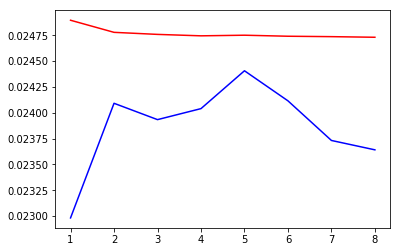

Valor final de e_val:  0.0247304014993

modelo  2  --- 


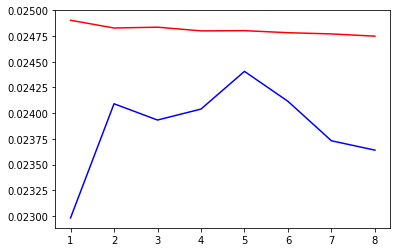

Valor final de e_val:  0.024748268852

modelo  3  --- 


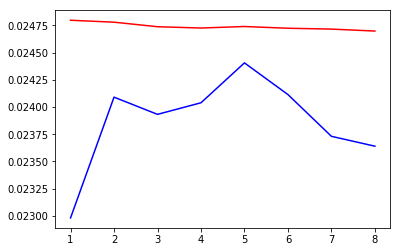

Valor final de e_val:  0.0246986373166


In [3]:
# separa os conjuntos de treinamento e validacao

dtrain = [(x, dest1) for x in src[0:8]]
dval   = [(x, dest1) for x in src[8:10]]

# cria os modelos

models = [multiresolution(se_list=x, trainingdata=[]) for x in [m1,m2,m3]]

# para cada imagem de treino adicionada, atualiza o operador e calcula 
# e_in sobre as 8 imagens de treino e e_val sobre as duas de validacao

i = 1
for model in models:
    
    print ''
    print 'modelo ', i, ' --- '
    e_in  = []
    e_val = []    
    
    for (srcimg, target) in dtrain:
        model.add_training_example(srcimg, target)
        
        e_in.append(model.error_in_sample())
        e_val.append(model.error(dval))
        
    plt.plot(range(1,9), e_in, 'b')
    plt.plot(range(1,9), e_val, 'r')
    plt.show()
    
    print 'Valor final de e_val: ', e_val[-1]
    i += 1

### Q1 passo 2 

Apesar disso, pelo valor final de $E_{val}$, percebe-se que o terceiro modelo tem uma pequena vantagem sobre os outros. Essa hipótese é, então, selecionada, para gerar o operador final, que será treinado, dessa vez sobre todo o conjunto de  dados. 

Abaixo, é possível ver o resultado, com o valor final de $E_{in}$ em torno de 0.0238, um pouco menor do que o que havia sido encontrado para o operador treinado somente em 8 imagens de treino. Cabe observar que, por termos utilizado o conjunto de validação para a seleção de modelo, a esperança do erro $E_{out}$ pode ter um viés para menos. Além disso, é mostrada a aplicação desse operador sobre uma das imagens.

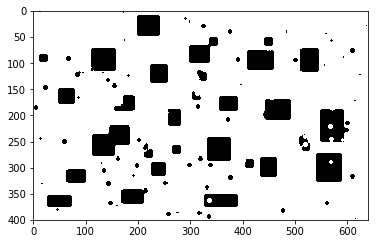

erro :  0.0238302839718


In [95]:
psi1 = multiresolution(se_list=m3, trainingdata=dtrain+dval)
draw_img(psi1.apply(dtrain[0][0]))
print 'erro : ', psi1.error(dtrain + dval)

### Q1 hipótese alternativa

Além das hipóteses previstas no enunciado, a título de curiosidade, foi acrescentada uma nova hipótese, começando de uma janela maior, 31x31. O resultado dessas hipóteses sobre os mesmos conjuntos de treino e validação do primeiro passo podem ser vistos a seguir, onde é possível notar que, nesse caso, as curvas $E_{in}$ e $E_{val}$ se comportam mais próximo do esperado, com $E_{in}$ crescendo lentamente e $E_{val}$ caindo, com valor próximo de 0.017, uma melhora de 30% em relação ao melhor dos modelos com elementos estruturantes 5x5. No entanto, a grande distância entre $E_{in}$ e $E_{val}$ mostra que, provavelmente, esse modelo pode não se adaptar tão bem a imagens muito diferentes das usadas para treino.

O resultado da aplicação desse modelo sobre todo o conjunto de dados também é mostrado. Nesse caso, o erro do treinamento $E_{in}$ fica bem mais baixo, chegando a 0.00018.

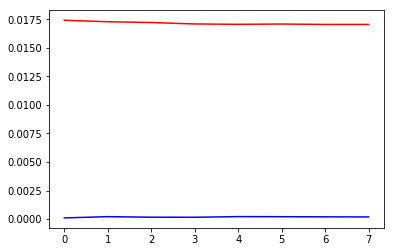

Valor final de e_val:  0.0170602569783


In [97]:
m31 = multiresolution(se_list = [se_box(15), se_dots, se_singledot], trainingdata = [])
e_in  = []
e_val = []   

for (srcimg, target) in dtrain:
    m31.add_training_example(srcimg, target)

    e_in.append(m31.error_in_sample())
    e_val.append(m31.error(dval))

plt.plot(e_in, 'b')
plt.plot(e_val, 'r')
plt.show()

print 'Valor final de e_val: ', e_val[-1]


Treinando sobre todas as imagens:


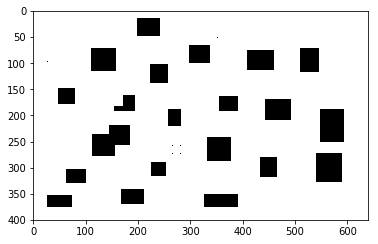

erro :  0.000179884802836


In [96]:
print 'Treinando sobre todas as imagens:'
    
m31f = multiresolution(se_list = [se_box(15), se_dots, se_singledot], trainingdata = dtrain + dval)     
draw_img(m31f.apply(dtrain[0][0]))
print 'erro : ', m31f.error(dtrain + dval)

# Q2. 
Considere novamente o problema de filtrar ruído. Utilizando as imagens da pasta imgs/q2/, explore diferentes funções booleanas para filtrar ruído. A operação **abertura** é definida como uma **erosão** seguida por uma **dilatação**, isto é $\delta_{B2}\epsilon_{B1}$, onde $B1$ e $B2$ são os elementos estruturantes. De modo semelhante, a função **fechamento** é definida por uma **dilatação** seguida por uma **erosão** ($\epsilon_{B2}\delta_{B1}$). Baseado nas funções *erosion* e *dilation* definidas em mac0460_5832/utils.py, teste os seguintes espaços de hipóteses:

1. Abertura;
2. Fechamento;
3. Abertura seguida de fechamento;

Para cada espaço de hipóteses, defina diferentes funções variando $B1$ e $B2$ (ou seja, crie as funções de maneira análoga à seguinte definição para um conjunto de aberturas: $\mathcal{F} = \{\psi_{B1B2}: \psi =  \delta_{B2}\epsilon_{B1}, B1, B2 \subseteq W_{3x3} \}$, onde $W_{3x3}$ é a janela 3x3). Mostre a função que tem menor erro e verifique o seu desempenho nos dados de teste.

Obs: existe no utils.py funções para abertura e fechamento. No entanto, essas funções utilizam o mesmo elemento estruturante para a erosão e dilatação, não permitindo o uso de diferentes elementos estruturantes. 

In [76]:
# 1- define os elementos estruturantes e as operacoes de abertura e fechamento

se1 = np.array([[False, False, False],[True,True, True],[False,False,False]])
se2 = np.array([[False, True, False],[False,True,False],[False,True,False]])
se3 = se_cross(1)
se4 = se_box(1)

struct_elems = [se1, se2, se3, se4]

def abertura(img, se_er, se_di):
    return dilation(f=erosion(f=img, b=se_er), b=se_di)
    
def fechamento(img, se_er, se_di):
    return erosion(f=dilation(f=img, b=se_di), b=se_er)


# 2 - carrega as imagens

dest2 = read_img("imgs/q2/dest.png")

dtrain = [read_img("imgs/q2/src0.png"), read_img("imgs/q2/src1.png"),
       read_img("imgs/q2/src2.png"), read_img("imgs/q2/src3.png"),
       read_img("imgs/q2/src4.png")]

dval = [read_img("imgs/q2/test0.png"), read_img("imgs/q2/test1.png")]

Conforme definido acima, os elementos estruturantes testados são um total de 4 para erosão (quadrado, cruz, faixa horizontal e faixa vertical)  e os mesmos 4 para dilatação. Isso resulta nos espaços de hipóteses de 16 aberturas, 16 fechamentos e 256 combinações de aberturas seguidas de fechamentos.

Os três espaços de hipóteses estão descritos a seguir. Em cada um dos casos, as hipóteses vencedoras no conjunto de treinamento resultaram em erosão com o elemento estruturante em forma de quadrado (caixa) 3x3 e a dilatação com o elemento estruturante em forma de cruz 3x3.

No caso de abertura e fechamento simples, as hipóteses vencedoras tiveram $E_{in}$ um pouco acima de 0.1 e $E_{out}$ entre 0.021 e 0.022. Já para a compoisçao de abertura e fechamento, $E_{in}$ foi de 0.08 e $E_{out}$ de 0.016, indicando uma melhora de cerca de 25% em relação ao uso de somente uma das duas funções.

(Obs.: Por alguma questão na função de desenhar imagens, a imagem com todos os valores True (caixa 3x3) está sendo mostrada como pintada de branco em vez de preto)

Hipotese vencedora no espaco de hipoteses de aberturas (16 hipoteses) 

Erro medio no conjunto de treinamento:  0.1043125

Elementos estruturantes de erosao e dilatacao


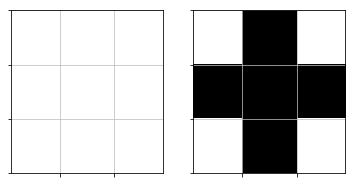

Desempenho no conjunto de validacao
Erro:  0.021


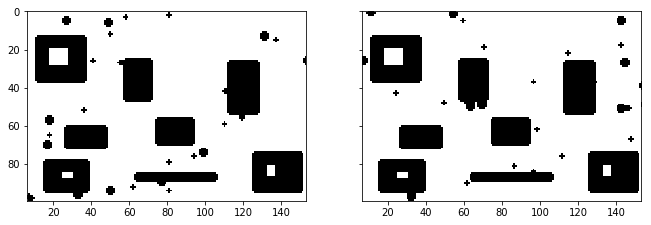

In [87]:
min1 = len(dtrain)
gt1 = []
for se_di in struct_elems:
    for se_er in struct_elems:
        erro = 0
        for img in dtrain:
            erro += img_dist(abertura(img, se_er, se_di), dest2)
        if erro < min1:
            min1 = erro
            gt1 = [se_er, se_di]
            
print 'Hipotese vencedora no espaco de hipoteses de aberturas (16 hipoteses) '
print ''
print 'Erro medio no conjunto de treinamento: ', min1
print ''
print 'Elementos estruturantes de erosao e dilatacao'
draw_img_pair(gt1[0], gt1[1], figsz=(6, 3))
print 'Desempenho no conjunto de validacao'
res10 = abertura(dval[0], gt1[0], gt1[1])
res11 = abertura(dval[1], gt1[0], gt1[1])
erro = ( img_dist(res10, dest2) + img_dist(res11, dest2) ) / 2
print 'Erro: ', erro
draw_img_pair(res10, res11, figsz=(11, 3.5))

Hipotese vencedora no espaco de hipoteses de fechamentos (16 hipoteses) 

Erro medio no conjunto de treinamento:  0.1085625

Elementos estruturantes de erosao e dilatacao


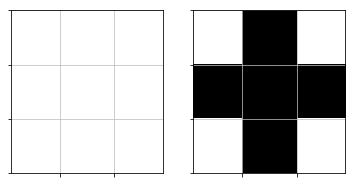

Desempenho no conjunto de validacao
Erro:  0.021625


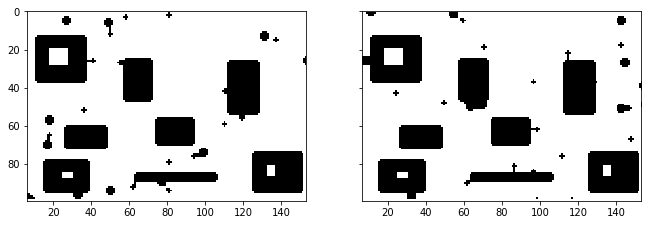

In [88]:
min2 = len(dtrain)
gt2 = []
for se_di in struct_elems:
    for se_er in struct_elems:
        erro = 0
        for img in dtrain:
            erro += img_dist(fechamento(img, se_er, se_di), dest2)
        if erro < min2:
            min2 = erro
            gt2 = [se_er, se_di]
            
print 'Hipotese vencedora no espaco de hipoteses de fechamentos (16 hipoteses) '
print ''
print 'Erro medio no conjunto de treinamento: ', min2
print ''
print 'Elementos estruturantes de erosao e dilatacao'
draw_img_pair(gt2[0], gt2[1], figsz=(6, 3))
print 'Desempenho no conjunto de validacao'
res20 = fechamento(dval[0], gt2[0], gt2[1])
res21 = fechamento(dval[1], gt2[0], gt2[1])
erro = ( img_dist(res20, dest2) + img_dist(res21, dest2) ) / 2
print 'Erro: ', erro
draw_img_pair(res20, res21, figsz=(11, 3.5))              
            


Hipotese vencedora no espaco de hipoteses de aberturas seguidas de fechamento (256 hipoteses)

Erro medio no conjunto de treinamento:  0.0811875

Elementos estruturantes de erosao e dilatacao para a abertura


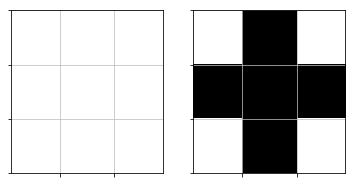

Elementos estruturantes de erosao e dilatacao para o fechamento


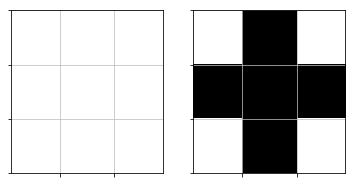

Desempenho no conjunto de validacao
Erro:  0.0161875


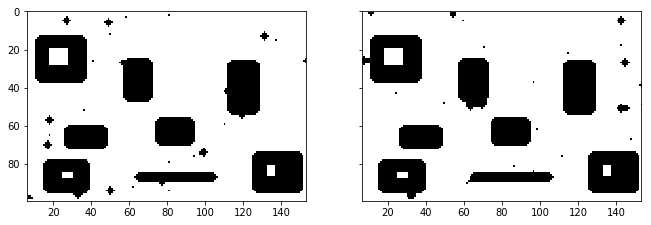

In [89]:
min3 = len(dtrain)
gt3 = []
for se_di in struct_elems:
    for se_er in struct_elems:
        for se_er2 in struct_elems:
            for se_di2 in struct_elems:
                erro = 0
                for img in dtrain:
                    erro += img_dist(fechamento(abertura(img, se_er, se_di), se_er2, se_di2), dest2)
                if erro < min3:
                    min3 = erro
                    gt3 = [se_er, se_di, se_er2, se_di2]
                    
print 'Hipotese vencedora no espaco de hipoteses de aberturas seguidas de fechamento (256 hipoteses)'
print ''
print 'Erro medio no conjunto de treinamento: ', min3
print ''
print 'Elementos estruturantes de erosao e dilatacao para a abertura'
draw_img_pair(gt3[0], gt3[1], figsz=(6, 3))
print 'Elementos estruturantes de erosao e dilatacao para o fechamento'
draw_img_pair(gt3[2], gt3[3], figsz=(6, 3))

print 'Desempenho no conjunto de validacao'
res30 = fechamento(abertura(dval[0], gt3[0], gt3[1]), gt3[2], gt3[3])
res31 = fechamento(abertura(dval[1], gt3[0], gt3[1]), gt3[2], gt3[3])
erro = ( img_dist(res30, dest2) + img_dist(res31, dest2) ) / 2
print 'Erro: ', erro
draw_img_pair(res30, res31, figsz=(11, 3.5))
                